<a href="https://colab.research.google.com/github/dhuMuhammadasif/test/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('data.csv')

train_x = np.array(df['vt'], dtype=np.float64)
train_y = np.array(df['fx'], dtype=np.float64)
print(train_x.shape, train_y.shape)


(2432,) (2432,)


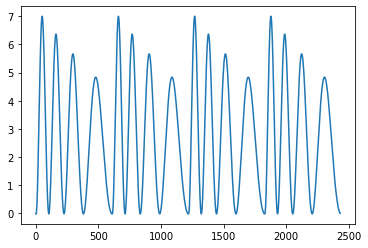

In [ ]:
plt.plot(train_x)
plt.show()


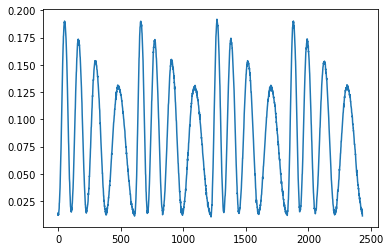

In [ ]:
plt.plot(train_y)
plt.show()

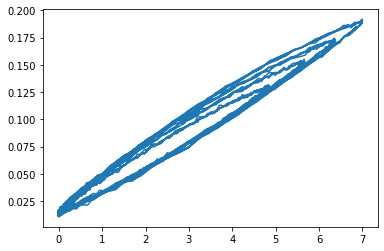

In [ ]:
plt.plot(train_x, train_y)
plt.show()

In [ ]:
def ewma_vectorized(data, window):
    alpha = 3 /(window + 3)
    alpha_rev = 1 - alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+2)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    
    return out

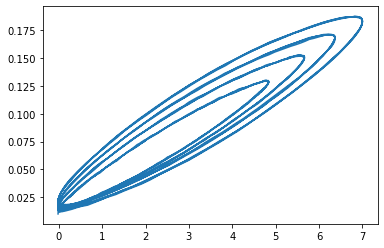

In [ ]:
train_y = ewma_vectorized(train_y, 11)
plt.plot(train_x, train_y)
plt.show()


In [ ]:
minimas = signal.argrelmin(train_x)[0]
maximas = signal.argrelmax(train_x)[0]

minimas_values = train_x[minimas]
maximas_values = train_x[maximas]

minimas_values, maximas_values

(array([-0.01556396, -0.01556396, -0.01556396, -0.01586914, -0.01586914,
        -0.01586914, -0.01617432, -0.01464844, -0.01464844, -0.01678467,
        -0.01525879, -0.01525879, -0.01647949]),
 array([7.0010376 , 6.36749268, 5.66375732, 4.83795166, 7.0010376 ,
        6.36688232, 5.6640625 , 4.83825684, 7.0010376 , 6.36627197,
        5.66345215, 4.83734131, 7.0010376 , 6.36810303, 5.66345215,
        4.83764648]))

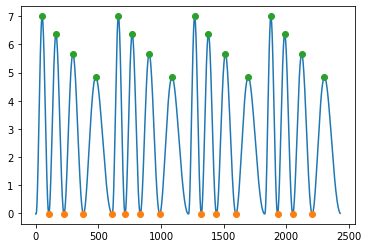

In [ ]:
plt.plot(train_x)
plt.plot(minimas, minimas_values, 'o')
plt.plot(maximas, maximas_values, 'o')
plt.show()

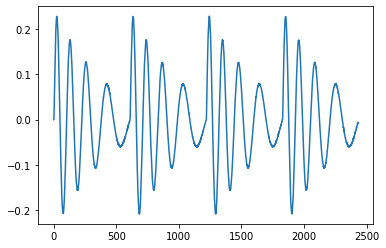

In [ ]:
x_diff = np.diff(train_x)
x_diff = np.append(x_diff, x_diff[-1])
plt.plot(x_diff)
plt.show()

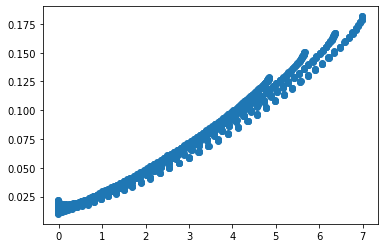

In [ ]:
train_x_inc = train_x[x_diff >= 0]
train_y_inc = train_y[x_diff >= 0]

plt.scatter(train_x_inc, train_y_inc)

In [ ]:
def f_inc(x, xp, f_xp, a, b, c, d):
    return (a - b*np.exp(-d*(xp - x)))*(x - xp) + c*f_xp


In [ ]:
def predict(x, maximas, a, b, c, d):
    xp = maximas[0]
    maximas = maximas[1:]
    f_xp = 1 - np.exp(-xp)
    f_x = np.zeros(x.shape)
    for i in range(x.shape[0]):
        f_x[i] = f_inc(x[i], xp, f_xp, a, b, c, d)
        if x[i] == xp:
            xp = maximas[0]
            maximas = maximas[1:]
            f_xp = 1 - np.exp(-xp)
    return f_x


In [ ]:
def cost_f_inc(x, y, maximas,  a, b, c, d):
    y_pred = predict(x, maximas, a, b, c, d)
    return np.sum((y - y_pred)**2)


In [ ]:
a_inc = 0.232
b_inc = 0.012
c_inc = 1.0812
d_inc = 0.0001


In [ ]:
predict_y = predict(train_x_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)
predict_y = ewma_vectorized(predict_y, 11)

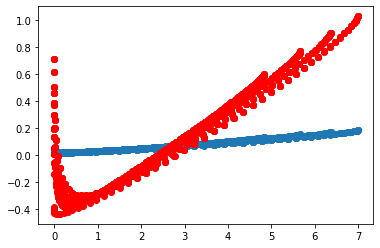

In [ ]:
plt.scatter(train_x_inc, train_y_inc)
plt.scatter(train_x_inc, predict_y, c='r')

In [ ]:
cost = cost_f_inc(train_x_inc, train_y_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)
cost

201.86762445361026

In [ ]:
def grad_a(x, y, maximas, a, b, c, d):
    y_pred = predict(x, maximas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    a_deriv = np.zeros(x.shape)
    xp = maximas[0]
    maximas = maximas[1:]
    for i in range(x.shape[0]):
        a_deriv[i] = x[i] - xp
        if x[i] == xp:
            xp = maximas[0]
            maximas = maximas[1:]
    return np.sum(cost_deriv*a_deriv)


def grad_b(x, y, maximas, a, b, c, d):
    y_pred = predict(x, maximas, a, b, c, d)
    c_deriv = 2*(y - y_pred)
    b_deriv = np.zeros(x.shape)
    xp = maximas[0]
    maximas = maximas[1:]
    for i in range(x.shape[0]):
        b_deriv[i] = -np.exp(-d*(xp - x[i]))*(x[i] - xp)
        if x[i] == xp:
            xp = maximas[0]
            maximas = maximas[1:]
    return np.sum(c_deriv*b_deriv)


def grad_c(x, y, maximas, a, b, c, d):
    y_pred = predict(x, maximas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    c_deriv = np.zeros(x.shape)
    xp = maximas[0]
    maximas = maximas[1:]
    f_xp = 1 - np.exp(-xp)
    for i in range(x.shape[0]):
        c_deriv[i] = f_xp
        if x[i] == xp:
            xp = maximas[0]
            maximas = maximas[1:]
            f_xp = 1 - np.exp(-xp)
    return np.sum(cost_deriv*c_deriv)


def grad_d(x, y, maximas, a, b, c, d):
    y_pred = predict(x, maximas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    d_deriv = np.zeros(x.shape)
    xp = maximas[0]
    maximas = maximas[1:]
    for i in range(x.shape[0]):
        d_deriv[i] = b*np.exp(-d*(xp - x[i]))*(x[i] - xp)*(xp - x[i])
        if x[i] == xp:
            xp = maximas[0]
            maximas = maximas[1:]
    return np.sum(cost_deriv*d_deriv)


In [ ]:
a_derv = grad_a(train_x_inc, train_y_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)
b_derv = grad_b(train_x_inc, train_y_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)
c_derv = grad_c(train_x_inc, train_y_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)
d_derv = grad_d(train_x_inc, train_y_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)

a_derv, b_derv, c_derv, d_derv

(-975.4878854423984,
 974.4431891589769,
 -231.22641619058095,
 -125.31663973041121)

In [ ]:
def gradient_descent(x, y, maximas, a, b, c, d, alpha, iterations):
    costs = []
    for i in range(iterations):
        y_pred = predict(x, maximas, a, b, c, d)
        cost = cost_f_inc(x, y, maximas, a, b, c, d)
        costs.append(cost)
        if i % 100 == 0:
            print(f'Iteration {i}, cost: {cost}')
        a_grad = grad_a(x, y, maximas, a, b, c, d)
        b_grad = grad_b(x, y, maximas, a, b, c, d)
        c_grad = grad_c(x, y, maximas, a, b, c, d)
        d_grad = grad_d(x, y, maximas, a, b, c, d)
        a = a + alpha*a_grad
        b = b + alpha*b_grad
        c = c + alpha*c_grad
        d = d + alpha*d_grad
    return a, b, c, d, costs


In [ ]:
a_inc, b_inc, c_inc, d_inc, costs = gradient_descent(
    train_x_inc, train_y_inc, maximas_values, a_inc, b_inc, c_inc, d_inc, 0.00001, 10000)


Iteration 0, cost: 201.86762445361026
Iteration 100, cost: 113.69465037267379
Iteration 200, cost: 28.285374007655506
Iteration 300, cost: 7.831634814471726
Iteration 400, cost: 3.5671799448974104
Iteration 500, cost: 2.542615416483338
Iteration 600, cost: 2.1306723600118387
Iteration 700, cost: 1.8555237958884536
Iteration 800, cost: 1.6300520391249536
Iteration 900, cost: 1.4357561480072314
Iteration 1000, cost: 1.266481933728696
Iteration 1100, cost: 1.1185886735343966
Iteration 1200, cost: 0.9892083600216945
Iteration 1300, cost: 0.8759071169236801
Iteration 1400, cost: 0.7765893217087131
Iteration 1500, cost: 0.6894460368141515
Iteration 1600, cost: 0.6129146351609067
Iteration 1700, cost: 0.5456441981852804
Iteration 1800, cost: 0.4864656024817019
Iteration 1900, cost: 0.4343657749639688
Iteration 2000, cost: 0.38846563586129623
Iteration 2100, cost: 0.34800125665361503
Iteration 2200, cost: 0.3123077887351341
Iteration 2300, cost: 0.28080576145582703
Iteration 2400, cost: 0.2529

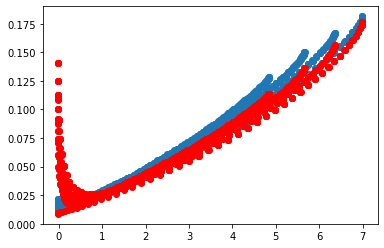

In [ ]:
y_pred_inc = predict(train_x_inc, maximas_values, a_inc, b_inc, c_inc, d_inc)
y_pred_inc = ewma_vectorized(y_pred_inc, 11)
plt.scatter(train_x_inc, train_y_inc)
plt.scatter(train_x_inc, y_pred_inc, c='r')


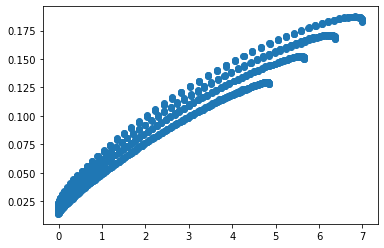

In [ ]:
train_x_dec = train_x[x_diff < 0]
train_y_dec = train_y[x_diff < 0]

plt.scatter(train_x_dec, train_y_dec)


In [ ]:
def f_dec(x, xp, f_xp, a, b, c, d):
    return (a - b*np.exp(d*(xp - x)))*(x - xp) + c*f_xp


In [ ]:
def predict_dec(x, minimas, a, b, c, d):
    xp = minimas[0]
    minimas = minimas[1:]
    f_xp = 1 - np.exp(xp)
    f_x = np.zeros(x.shape)
    for i in range(x.shape[0]):
        f_x[i] = f_dec(x[i], xp, f_xp, a, b, c, d)
        if x[i] == xp:
            xp = minimas[0]
            minimas = minimas[1:]
            f_xp = 1 - np.exp(xp)
    return f_x


In [ ]:
def cost_f_dec(x, y, minimas,  a, b, c, d):
    y_pred = predict_dec(x, minimas, a, b, c, d)
    return np.sum((y - y_pred)**2)


In [ ]:
a_dec = 0.232
b_dec = 0.012
c_dec = 1.2258
d_dec = 0.0001

In [ ]:
predict_y = predict_dec(train_x_dec, minimas_values,
                        a_dec, b_dec, c_dec, d_dec)


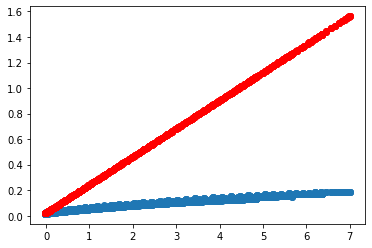

In [ ]:
plt.scatter(train_x_dec, train_y_dec)
plt.scatter(train_x_dec, predict_y, c='r')


In [ ]:
cost = cost_f_dec(train_x_dec, train_y_dec, minimas_values, a_dec, b_dec, c_dec, d_dec)
cost

598.0812943967599

In [ ]:
def grad_a_dec(x, y, minimas, a, b, c, d):
    y_pred = predict_dec(x, minimas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    a_deriv = np.zeros(x.shape)
    xp = minimas[0]
    minimas = minimas[1:]
    for i in range(x.shape[0]):
        a_deriv[i] = x[i] - xp
        if x[i] == xp:
            xp = minimas[0]
            minimas = minimas[1:]
    return np.sum(cost_deriv*a_deriv)


def grad_b_dec(x, y, minimas, a, b, c, d):
    y_pred = predict_dec(x, minimas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    b_deriv = np.zeros(x.shape)
    xp = minimas[0]
    minimas = minimas[1:]
    for i in range(x.shape[0]):
        b_deriv[i] = -np.exp(d*(xp - x[i]))*(x[i] - xp)
        if x[i] == xp:
            xp = minimas[0]
            minimas = minimas[1:]
    return np.sum(cost_deriv*b_deriv)


def grad_c_dec(x, y, minimas, a, b, c, d):
    y_pred = predict_dec(x, minimas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    c_deriv = np.zeros(x.shape)
    xp = minimas[0]
    minimas = minimas[1:]
    f_xp = 1 - np.exp(xp)
    for i in range(x.shape[0]):
        c_deriv[i] = f_xp
        if x[i] == xp:
            xp = minimas[0]
            minimas = minimas[1:]
    return np.sum(cost_deriv*c_deriv)


def grad_d_dec(x, y, minimas, a, b, c, d):
    y_pred = predict_dec(x, minimas, a, b, c, d)
    cost_deriv = 2*(y - y_pred)
    d_deriv = np.zeros(x.shape)
    xp = minimas[0]
    minimas = minimas[1:]
    for i in range(x.shape[0]):
        d_deriv[i] = -b*np.exp(d*(xp - x[i]))*(xp - x[i])*(x[i] - xp)
        if x[i] == xp:
            xp = minimas[0]
            minimas = minimas[1:]
    return np.sum(cost_deriv*d_deriv)


In [ ]:
a_derv = grad_a_dec(train_x_dec, train_y_dec,
                    minimas_values, a_dec, b_dec, c_dec, d_dec)
b_derv = grad_b_dec(train_x_dec, train_y_dec,
                    minimas_values, a_dec, b_dec, c_dec, d_dec)
c_derv = grad_c_dec(train_x_dec, train_y_dec,
                    minimas_values, a_dec, b_dec, c_dec, d_dec)
d_derv = grad_d_dec(train_x_dec, train_y_dec,
                    minimas_values, a_dec, b_dec, c_dec, d_dec)

a_derv, b_derv, c_derv, d_derv


(-6168.612019063834,
 6165.551886347573,
 -21.825443628863326,
 -367.11834522158625)

In [ ]:
def gradient_descent_dec(x, y, minimas, a, b, c, d, alpha, iterations):
    costs = []
    for i in range(iterations):
        cost = cost_f_dec(x, y, minimas, a, b, c, d)
        costs.append(cost)
        if i % 100 == 0:
            print(f'Iteration {i}, cost: {cost}')
        a_grad = grad_a_dec(x, y, minimas, a, b, c, d)
        b_grad = grad_b_dec(x, y, minimas, a, b, c, d)
        c_grad = grad_c_dec(x, y, minimas, a, b, c, d)
        d_grad = grad_d_dec(x, y, minimas, a, b, c, d)

        a = a + alpha*a_grad
        b = b + alpha*b_grad
        c = c + alpha*c_grad
        d = d + alpha*d_grad
    return a, b, c, d, costs


In [ ]:
a_dec, b_dec, c_dec, d_dec, costs_dec = gradient_descent_dec(
    train_x_dec, train_y_dec, minimas_values, a_dec, b_dec, c_dec, d_dec, 0.00001, 1000)


Iteration 0, cost: 598.0812943967599
Iteration 100, cost: 0.10736383680573361
Iteration 200, cost: 0.10691939194595365
Iteration 300, cost: 0.10680310951632102
Iteration 400, cost: 0.10677168319825062
Iteration 500, cost: 0.10676236827298022
Iteration 600, cost: 0.1067588375737164
Iteration 700, cost: 0.10675682317460886
Iteration 800, cost: 0.1067552068855494
Iteration 900, cost: 0.10675369540879681


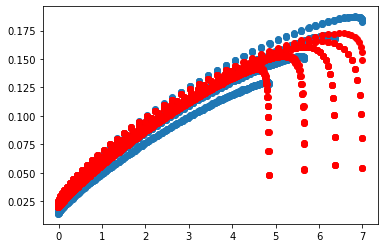

In [ ]:
y_pred_dec = predict_dec(train_x_dec, minimas_values, a_dec, b_dec, c_dec, d_dec)
y_pred_dec = ewma_vectorized(y_pred_dec, 11)
plt.scatter(train_x_dec, train_y_dec)
plt.scatter(train_x_dec, y_pred_dec, c='r')


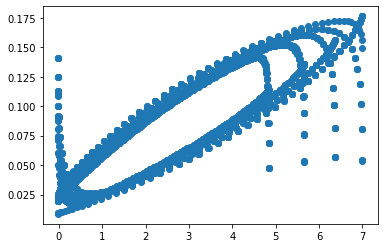

In [ ]:
train_x_1 = np.append(train_x_inc, train_x_dec)
y_pred = np.append(y_pred_inc, y_pred_dec)
plt.scatter(train_x_1, y_pred)
# plt.scatter(train)